- **Created:** [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) 
- **Date:** July 2025
- **conda environment**: This uses the [mri environment](https://github.com/MRC-CBU/COGNESTIC/tree/main/mri_environment.yml)

# Task-based Functional Connectivity

This notebook explains two types of fMRI connectivity for tasks (for a single subject):

1. "Beta-Series Regression" (BSR) to test whether the correlation between single-trial BOLD responses between two regions/voxels differs as a function of trial-type (condition). This starts with BSR between two ROIs (using NiftiMaskers from previous notebooks) and then shows BSR between a seed ROI and all other voxels in an image. 

2. "Psycho-Physiological Interactions" (PPIs) which also tests for condition-specific differences in connectivity but at the level of scan timeseries, rather than Beta timeseries. This involves creating a first-level fMRI model that contains one "physiological" regressor for the timeseries from one "seed" ROI or voxel, one (or more) "psychological" regressors coding the task (as in conventional fMRI models), and most importantly, one (or more) regressors capturing the the interaction between these two - the "PPI" regressor(s) of interest.

See [https://pubmed.ncbi.nlm.nih.gov/39464064/](https://pubmed.ncbi.nlm.nih.gov/39464064/) for a review of different task-based methods.

Note that there are more complex dynamical models (like DCM or HMMs) that get closer to measuring true "effective connectivity" (by simulating a full network of regions, see [Stephan & Friston (2011)](https://pmc.ncbi.nlm.nih.gov/articles/PMC3013343/) for example) - but these are not covered here.

There are also many powerful data-driven methods (like ICA) that can be used to estimate function networks of regions with similar timeseries (see for example [Smitha et al (2017)](https://pmc.ncbi.nlm.nih.gov/articles/PMC5524274) for example review) - which can be used for state-based data like resting-state - these are covered in other notebooks. 

Finally, we are using unidimensional connectivity, averaging values across voxels within each ROI, though there are also multidimensional ways to estimate connectivity (see [Basti et al (2020)](https://pubmed.ncbi.nlm.nih.gov/32682988/) for example review).

## 0. Getting Ready

As usual, we need some python packages like below:

In [1]:
import matplotlib.pyplot as plt # plotting
# to show plots in cell
%matplotlib inline   

import os           # To interact with the operating system, including files and paths (e.g. path.join)
import bids.layout  # To fetch data from BIDS-compliant datasets
import numpy        # This lets python process arrays/matrices
import pandas       # To use "dataframes"      
import nibabel      # Basic nifti image utilities

import nilearn                  # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn.glm.first_level import FirstLevelModel
from nilearn.maskers import NiftiMasker, NiftiSpheresMasker # For extracting data from images
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import datasets    # for atlases below
from nilearn.connectome import ConnectivityMeasure

import scipy                     # statistical tools
from scipy.stats import pearsonr # like Pearson correlation

And set-up our input and output directories:

In [2]:
wd = '/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/' 
out_dir = os.path.join(wd, 'task_con')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)
print(f"Working directory currently {os.getcwd()}")

fmri_data_dir = '/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data' 

#fmri_data_dir = os.path.join(wd, 'data') # data in BIDS format
#fmri_results_dir = os.path.join(wd, 'results') # results in BIDS format

layout = bids.layout.BIDSLayout(fmri_data_dir, derivatives = True)
#layout.add_derivatives(os.path.join(fmri_results_dir, 'first-level'))

Working directory currently /home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con


## 1. Task-based Beta-series regression

For Beta-Series Regression (BSR) we test whether the correlation (or regression slope) across two ROIs or voxels between their Beta values for single-trials differ across two or more conditions (trial-types).

First we need to estimate those single-trial Betas...

### 1.1 Extracting trial-specific responses (Betas)

Previously we used the onsets of all trials (of a given type) to convolve with an HRF and enter as a single regressor in a GLM. Here we are going to separate each onset into a separate regressor, so we have as many columns in our design matrix as there are total events. As long as the TR<SOA, we will have more scans (rows) than trials, so the Betas can be estimated by OLS (though regularised estimation is also possible). This approach is called "Least Squares All" (LSA).

Note that LSA can result in quite noisy Beta estimates (particularly when the time between events is short - see for example [Abdulrahman & Henson, 2016](https://pubmed.ncbi.nlm.nih.gov/26549299/)). An alternative is Least-Squares-Separate (LSS), which can improve estimates (by temporal regularisation), but is much more computationally expensive. In the interests of time, we will use LSA here, but see https://nilearn.github.io/dev/auto_examples/07_advanced/plot_beta_series.html for an example of the LSS approach.

We are going to focus on subject 15 as before, and need to get their preprocessing (fMRIPrep) BOLD data and event onsets:

In [3]:
sID = '15' # same subject we used before

bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename')
print("Found " + str(len(bold)) + " preprocessed functional files")

events_files = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print("Found " + str(len(events_files)) + " event files")

Found 9 preprocessed functional files
Found 9 event files


Next we need to give every famous and scrambled trial a unique name (based on the stimulus that was presented). We are going to focus on just trials involving Famous Faces (FF) and Scrambled Faces (SF), and more specifically their Initial presentation (Ini) and Delayed repetition (Del). We are ignoring Unfamiliar Faces just for simplicity. The reason we are also ignoring Immediate repeats is that they always follow initial presentations close in time, which means that their single-trial regressors (see below) are highly correlated, such that the response estimate for an initial trial is difficult to separate from that for its immediate repeat.

In [4]:
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
conditions_of_interest = ['IniFF', 'DelFF', 'IniSF', 'DelSF']
other_conditions = [val for val in conditions if val not in conditions_of_interest]

lsa_events = []
for run, events_file in enumerate(events_files):
    events_df = pandas.read_table(events_file)
    for j, event in enumerate(events_df['trial_type']):
        if event in conditions_of_interest:
            events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]
    events_df = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])
    lsa_events.append(events_df)

print(lsa_events[0])

      onset  duration trial_type
0     0.000     0.910  IniFFf005
1     3.124     0.996  IniFFf012
2     6.564     0.830      ImmFF
3     9.620     0.908  IniSFs007
4    12.894     0.885      IniUF
..      ...       ...        ...
88  380.126     0.914      DelUF
89  383.250     0.896      IniUF
90  386.423     0.818      DelUF
91  389.480     1.000      IniUF
92  392.804     0.955      ImmUF

[93 rows x 3 columns]


Note how the trials of no interest are still modelled in a single regressor per trial-type. We also need to re-get the confounds, like in the previous single-subject analysis notebook. Here is the resulting design matrix:

Slice timing reference: 0.487


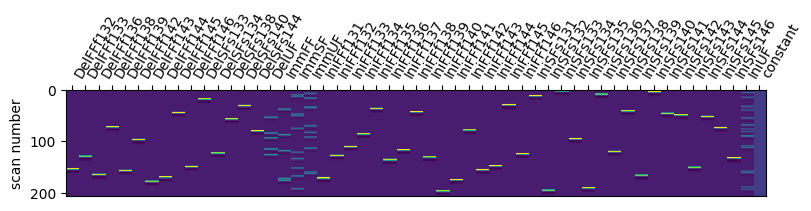

In [5]:
# example design matrix for first run
TR = layout.get_tr()

# reference slice
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  print('Slice timing reference:', slice_time_ref)

nvols = nibabel.load(bold[0]).shape[-1]
frame_times = numpy.linspace(0, (nvols - 1) * TR, nvols) + slice_time_ref # adjust for slice-timing

design_matrix = nilearn.glm.first_level.make_first_level_design_matrix(frame_times, 
                                                                       events = events_df, 
                                                                       hrf_model = 'spm', 
                                                                       drift_model = 'cosine', 
                                                                       high_pass = 0, 
                                                                       drift_order = None)
nilearn.plotting.plot_design_matrix(design_matrix, output_file=None)
fig = plt.gcf(); fig.set_size_inches(8,2); plt.show();

We can now fit create a proper GLM for each run, including confounds, etc, as in a previous notebook:

In [6]:
# Get the confounds of interest
confound_files = layout.get(subject = sID, datatype = 'func', desc = 'confounds', extension = ".tsv", return_type = 'filename')
relevant_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pandas.read_table(conf_file)
    conf_subset = this_conf[relevant_confounds].fillna(0) # replace NaN with 0
    confounds_for_glm.append(conf_subset)

# Get brain mask
brain_mask_file = layout.get(return_type='file', datatype='func', suffix='mask', desc='brain', space='MNI152NLin6Asym', extension='nii.gz')[0]
brain_mask = nibabel.load(brain_mask_file)

# Set-up GLM parameters
fmri_glm = FirstLevelModel(t_r = TR,
                           slice_time_ref = slice_time_ref,
                           hrf_model = 'spm',
                           drift_model = 'cosine',
                           drift_order = 1,
                           high_pass = 0.01,
                           smoothing_fwhm = None,
                           signal_scaling = (0, 1), # grand mean scaling only
                           noise_model = 'ols', # no need for 'ar1' if only care about Betas, should speed up
                           mask_img = brain_mask,
                           #memory = 'scratch'
                          );

Note that we are 1) not smoothing (since we are going to focus on ROIs), 2) using the quicker "ols" rather than "ar1" model of the error autocorrelation (since we do not care about precise statistics; only the Betas) and 3) only scaling to the mean over voxels and TRs in each run (the "(0,1)" option for the "signal_scaling" variable), since we do not want to adjust for global changes that might be caused by trial-specific responses.

We now run through all 9 runs, fitting the GLM, calculating the effect size (beta) for each initial FF and UF trial (to save in a 4D image for each run). Note this will take a while:

In [7]:
# Ready output directory
model_name = 'LSA_FF_SF' 
beta_dir = os.path.join(out_dir, model_name, 'sub-' + sID)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)

affine = nibabel.load(bold[0]).affine # need for writing 4D images below

beta_filenames = []
for run in range(len(bold)):
    # fit GLM
    run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);
    
    # Compute betas for each initial FF and UF trial
    trials_to_save = lsa_events[run]["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    lsa_beta_maps  = [] 
    print(f'Run {run+1}: Creating {len(trials_to_save)} beta images...')
    for trial in trials_to_save:
        beta_map = run_glm.compute_contrast(trial, output_type = 'effect_size');
        lsa_beta_maps.append(beta_map)

    # save trials as a 4D image so can load later
    print(f'Run {run+1}: Saving to a 4D file...')
    volumes = numpy.squeeze([lsa_beta_maps[trial].get_fdata() for trial in range(0,len(lsa_beta_maps))])
    data_4d = numpy.stack(volumes, axis=-1)  # Stack along the 4th dimension
    img_4d  = nibabel.Nifti1Image(data_4d, affine);
    beta_filenames.append(os.path.join(beta_dir, os.path.basename(bold[run]).split("space")[0] + model_name + '_betas.nii.gz'))
    nibabel.save(img_4d, beta_filenames[run]);
 
# Remove the cached directory
!rm -rf scratch/joblib/

/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 1: Creating 45 beta images...
Run 1: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 2: Creating 48 beta images...
Run 2: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 3: Creating 46 beta images...
Run 3: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 4: Creating 44 beta images...
Run 4: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 5: Creating 47 beta images...
Run 5: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 6: Creating 43 beta images...
Run 6: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 7: Creating 48 beta images...
Run 7: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 8: Creating 46 beta images...
Run 8: Saving to a 4D file...


/tmp/ipykernel_6215/2929465972.py:12: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);


Run 9: Creating 47 beta images...
Run 9: Saving to a 4D file...


(If you have already created these, and don't want to recreate with code above, then you can just run these lines:

```bash
model_name = 'LSA_FF_SF' 
beta_dir = os.path.join(out_dir, model_name, 'sub-' + sID)

beta_filenames = [] # name of 4D files that contain Beta estimates for single trials for each run
trial_labels = []
for run, events_file in enumerate(events_files):
    beta_file = os.path.join(beta_dir, os.path.basename(events_file).split("events")[0] + model_name + '_betas.nii.gz')
    print(beta_file)
    beta_filenames.append(beta_file)

print("Found " + str(len(beta_filenames)) + " 4D files, each with single-trial images for a run")
#print(labels_per_run)
```

### 1.2 ROI to ROI

We will start by estimating connectivity between just two ROIs: the functional fusiform ROI and the anatomical amygdala ROI from previous notebooks:

In [8]:
amyg_ROI = nibabel.load(os.path.join(out_dir, 'amygdala_mask.nii.gz'))
print(amyg_ROI.get_fdata().shape)
amyg_ROI = nilearn.image.resample_to_img(amyg_ROI, beta_filenames[0], interpolation='nearest', force_resample=True, copy_header=True) # resample ROI to bold resolution to save time when estimating glm below
print(amyg_ROI.get_fdata().shape)

fusi_ROI = nibabel.load(os.path.join(out_dir, 'FFA_sphere_and_faces-scrambled_fwe.nii.gz'))
print(fusi_ROI.get_fdata().shape)
#don't need to resample fusfi_ROI because was created from same data
#fusi_ROI = nilearn.image.resample_to_img(fusi_ROI, beta_filenames[0], interpolation='nearest', force_resample=True, copy_header=True) 

amyg_masker = NiftiMasker(amyg_ROI)
fusi_masker = NiftiMasker(fusi_ROI)

(64, 76, 64)
(61, 73, 61)
(61, 73, 61)


Then we concatenate the single-trial Betas for each ROI and average over voxels in that ROI (will take a short while):

In [9]:
fusi_data_per_run = []
amyg_data_per_run = []
for run in range(len(beta_filenames)):
    print(beta_filenames[run])

    fusi_data = fusi_masker.fit_transform(beta_filenames[run])
    fusi_data = numpy.mean(fusi_data, axis=1) # average across voxels
    fusi_data_per_run.append(fusi_data)

    amyg_data = amyg_masker.fit_transform(beta_filenames[run])
    amyg_data = numpy.mean(amyg_data, axis=1) # average across voxels
    amyg_data_per_run.append(amyg_data)

fusi_data = numpy.concatenate(fusi_data_per_run, axis=0)
amyg_data = numpy.concatenate(amyg_data_per_run, axis=0)
#print("Found " + str(fusi_data.shape[0]) + " single-trials in total")

/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-07_LSA_FF_SF_betas

We will also concatenate the trial labels:

In [10]:
trial_labels = []
for run, events_file in enumerate(events_files):
    events_df = pandas.read_table(events_file)
    trials_to_save = events_df["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    trials_to_save = [label[3:5] for label in trials_to_save] # Just select FF or SF characters
    trial_labels.extend(trials_to_save)
print(trial_labels)

trials_per_condition = []
conditions_of_interest = list(dict.fromkeys(trial_labels))
for con, condition in enumerate(conditions_of_interest):
    trials_per_condition.append([i for i, x in enumerate(trial_labels) if x == condition])
    print(f'{len(trials_per_condition[con])} {condition} trials')

['FF', 'FF', 'SF', 'FF', 'FF', 'FF', 'SF', 'SF', 'FF', 'FF', 'SF', 'FF', 'FF', 'SF', 'SF', 'SF', 'FF', 'SF', 'SF', 'FF', 'SF', 'FF', 'FF', 'SF', 'FF', 'FF', 'SF', 'FF', 'SF', 'SF', 'SF', 'FF', 'FF', 'FF', 'SF', 'SF', 'SF', 'FF', 'SF', 'FF', 'FF', 'SF', 'FF', 'FF', 'SF', 'SF', 'SF', 'FF', 'FF', 'SF', 'SF', 'FF', 'SF', 'FF', 'FF', 'SF', 'SF', 'SF', 'SF', 'SF', 'FF', 'SF', 'FF', 'SF', 'SF', 'SF', 'FF', 'SF', 'SF', 'FF', 'SF', 'FF', 'FF', 'FF', 'SF', 'FF', 'FF', 'FF', 'FF', 'SF', 'FF', 'FF', 'FF', 'SF', 'FF', 'FF', 'SF', 'SF', 'FF', 'FF', 'SF', 'SF', 'FF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'FF', 'FF', 'SF', 'SF', 'SF', 'FF', 'SF', 'SF', 'FF', 'SF', 'FF', 'SF', 'SF', 'SF', 'SF', 'FF', 'SF', 'FF', 'SF', 'SF', 'SF', 'FF', 'FF', 'FF', 'SF', 'FF', 'FF', 'SF', 'SF', 'FF', 'FF', 'FF', 'FF', 'FF', 'FF', 'FF', 'SF', 'SF', 'FF', 'FF', 'SF', 'FF', 'SF', 'FF', 'SF', 'SF', 'FF', 'FF', 'SF', 'FF', 'SF', 'FF', 'SF', 'SF', 'FF', 'SF', 'FF', 'FF', 'SF', 'SF', 'FF', 'FF', 'SF', 'FF', 'SF', 'SF', 'SF', 'FF

Let's plot the "Beta series" (a time-series of single-trial Betas) for each ROI, separately for each condition (FF and SF), as well as the Pearson R value for correlation between ROIs for each condition:

<Figure size 640x480 with 0 Axes>

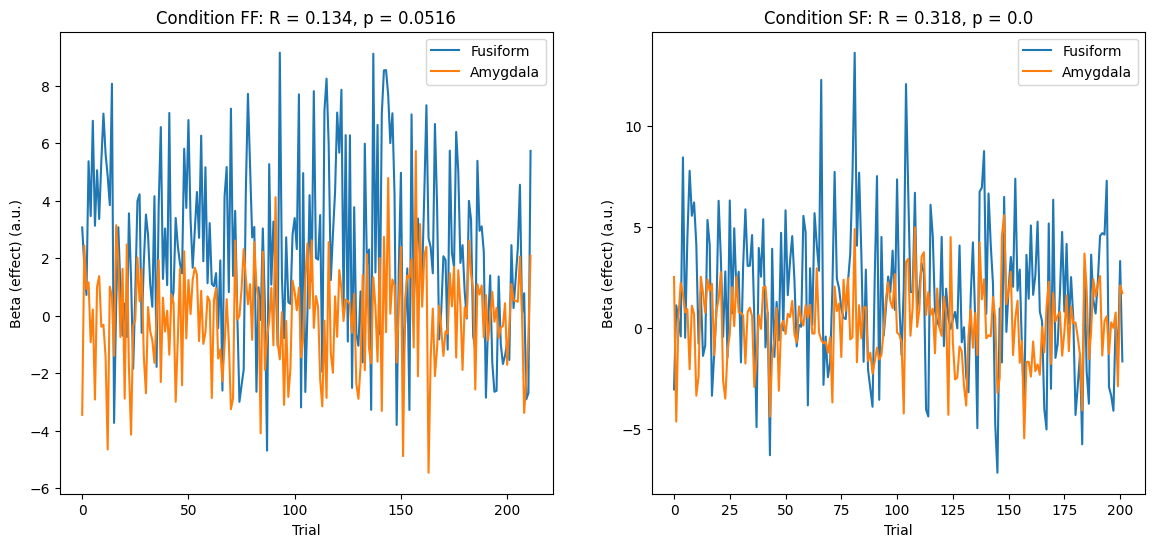

In [11]:
plt.figure(); 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6));

Rval_data = []
for ax in range(len(axs.flat)):
    pcor = pearsonr(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]])
    Rval_data.append(pcor.statistic)
    
    axs[ax].plot(fusi_data[trials_per_condition[ax]]);
    axs[ax].plot(amyg_data[trials_per_condition[ax]]);
#    axs[ax].plot(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]],'o');
    axs[ax].set_xlabel('Trial');
    axs[ax].set_ylabel('Beta (effect) (a.u.)');
    axs[ax].legend(['Fusiform', 'Amygdala']);
    axs[ax].set_title('Condition ' + conditions_of_interest[ax] + ": R = " + str(round(pcor.statistic,3)) + ", p = " + str(round(pcor.pvalue,4)));

Interestingly, the Fusiform and Amygdala ROIs seem to be more functionally connected for Scrambled than Famous faces, in that they are significantly positively correlated for SF but not (quite) for FF. However, we need to test whether this difference in correlations is significant. One way is to use a permutation test to estimate the probability of getting such a difference in R values under the null (see Notebook on basic statistics):

Permuted p-value for difference in R values being as big as -0.18 is 0.06


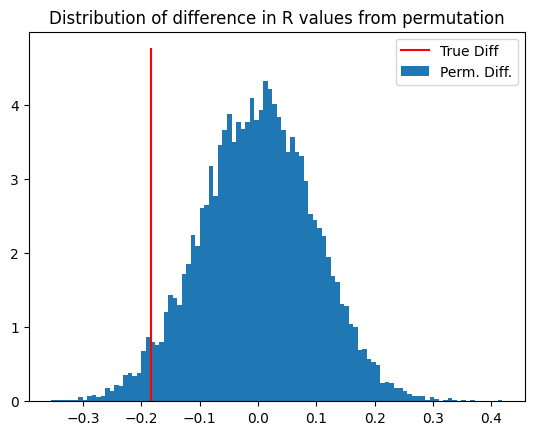

In [12]:
# generate null distributions of R-values for each condition
num_rand = int(1e4) # Number of randomisations
Rval = numpy.empty([len(conditions),num_rand])
for con, condition in enumerate(conditions_of_interest):
    fusi_samp = fusi_data[trials_per_condition[con]]
    
    for r in range(num_rand):
        amyg_perm = numpy.random.permutation(amyg_data[trials_per_condition[con]])
        pcor = pearsonr(fusi_samp, amyg_perm)
        Rval[con,r] = pcor.statistic

# create null distribution of difference and true difference (for FF-SF)
Rval_dif_data = Rval_data[0] - Rval_data[1]
Rval_dif_perm = Rval[0,:] - Rval[1,:]

# plot histogram of null (permuted) and true
pdf, bin_edges = numpy.histogram(Rval_dif_perm, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.plot([Rval_dif_data, Rval_dif_data], [0, 1.1*numpy.max(pdf)], 'r-')
plt.title('Distribution of difference in R values from permutation'); plt.legend(['True Diff', 'Perm. Diff.']);

pval = (numpy.sum(numpy.abs(Rval_dif_perm) >= numpy.abs(Rval_dif_data)) + 1) / (num_rand + 1) # two-tailed p-value (see stats notebook 00)
print(f'Permuted p-value for difference in R values being as big as {round(Rval_dif_data,2)} is {round(pval,3)}')

Thus the difference in correlations between FF and SF is not quite significant. There is also a parametric way to compare R-values, using the Fisher transform, which we show below because we will use later to estimate voxel-wise BSR in feasible times:

In [13]:
# Convert to Z-values using Fisher transform (atanh)
difZ = numpy.arctanh(Rval_data[0]) - numpy.arctanh(Rval_data[1]) # faces - scrambled
# Fisher test given number of observations in each condition
Zdif = difZ / numpy.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) 
#two-tailed
pval = scipy.stats.norm.cdf(-abs(Zdif)) + (1-scipy.stats.norm.cdf(abs(Zdif)))
print(f'Fisher p-value for difference in Z-values being as big as {round(difZ,2)} is {round(pval,3)}')

Fisher p-value for difference in Z-values being as big as -0.19 is 0.05


This is still borderline, though remember we are only analysing a single subject. We could calculate the regression slope for the other 15 participants, and do a one-sample T-test across participants to see if this fusiform-amygdala negative correlation is reliable across people.

### 1.2 ROI to whole brain

We can also map out BSR between a seed ROI/voxel and all other voxels in the brain. First, we load up the whole-brain data, smoothing by 10mm to get cleaner maps (depending on spatial scale of BSR differences).

In [14]:
brain_masker = NiftiMasker(smoothing_fwhm=10)

brain_data_per_run = []
for run in range(len(beta_filenames)):
    print(beta_filenames[run])
    brain_data = brain_masker.fit_transform(beta_filenames[run])
    brain_data_per_run.append(brain_data)
    
brain_data = numpy.concatenate(brain_data_per_run, axis=0)
print(brain_data.shape)

/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_FF_SF_betas.nii.gz
/home/cognestic/COGNESTIC/07_fMRI_Connectivity/data/task_con/LSA_FF_SF/sub-15/sub-15_ses-mri_task-facerecognition_run-07_LSA_FF_SF_betas

We can then calculate the Pearson correlation for all voxels by taking the dot product of the vector of fusiform beta-series with the matrix of beta-series for all brain voxels, and scaling by the respective norms of these beta-series (which is equivalent to the Pearson R value). We do this for each condition separately:

In [15]:
indices = trials_per_condition[0]; # FF
brain_corrs_con1 = numpy.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con1 = brain_corrs_con1 / (numpy.linalg.norm(fusi_data[indices]) * numpy.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con1 = numpy.arctanh(brain_corrs_con1) # Fisher Transform R value to Z value

indices = trials_per_condition[1] # SF
brain_corrs_con2 = numpy.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con2 = brain_corrs_con2 / (numpy.linalg.norm(fusi_data[indices]) * numpy.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con2 = numpy.arctanh(brain_corrs_con2) # Fisher Transform R value to Z value

Then we can do the Fisher test to see where differences in the correlations are significant:

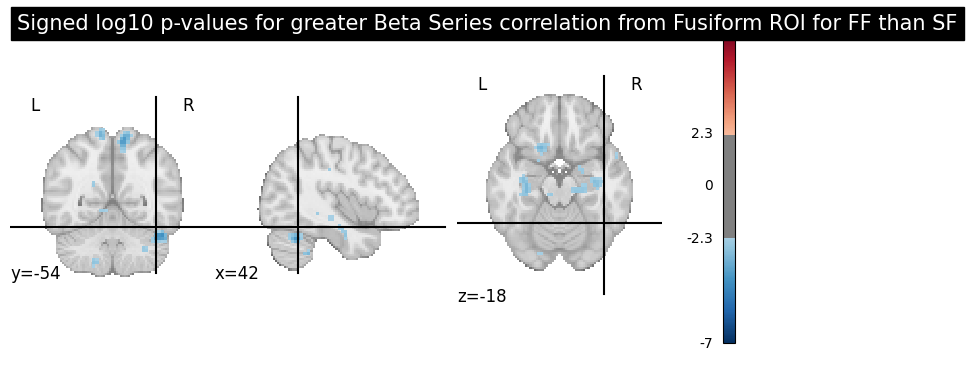

In [16]:
difZ = numpy.arctanh(brain_corrs_con1) - numpy.arctanh(brain_corrs_con2) # Faces > Scrambled
Zdif = difZ / numpy.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) # Fisher method for comparing two independent correlations
pval = scipy.stats.norm.cdf(-abs(Zdif)) + (1-scipy.stats.norm.cdf(abs(Zdif))) #two-tailed

# convert to negative log10 (see earlier notebook), multiplied by sign of difference, and then plot
sval = numpy.sign(difZ)
pval = sval * -numpy.log10(pval)

brain_diff_con_img = brain_masker.inverse_transform(pval)
fusi_coords = (42, -54, -18) # from Dace's notebook
display = nilearn.plotting.plot_stat_map(brain_diff_con_img, cut_coords=fusi_coords, threshold = -numpy.log10(0.005),
    title="Signed log10 p-values for greater Beta Series correlation from Fusiform ROI for " + conditions_of_interest[0] + " than " + conditions_of_interest[1])

Though they would not survive correction for mulitple comparisons, you can see several medial clusters around the amygdala where functional connectivity is greater for scrambled faces (blue), which is consistent with the ROI-to-ROI result.

## 2. Psycho-Physiological Interactions (PPIs)

This method estimates statistics at the level of the original fMRI timeseries, rather than having to first estimate single-trial Betas. First we need to extract the BOLD timeseries for the fusiform ROI (seed region):

In [17]:
fusi_data_per_run = []
for run in range(len(bold)):
    print(bold[run])
    fusi_data = fusi_masker.fit_transform(bold[run])
    fusi_data = numpy.mean(fusi_data, axis=1) # average across voxels
    fusi_data_per_run.append(fusi_data)

/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-02_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-03_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-04_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-05_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRe

Then we return to the original design matrix, and add 3 new regressors. The first is the BOLD timeseries from the fusiform ROI seed above (the "physiological" aspect of the PPI). The other 2 are the interaction terms, namely the element-wise product of the fusiform timeseries and the "psychological" regressors (already in the design matrix) for the two conditions of interest: FF and SF. (These are the two PPI regressors that we will later contrast.)

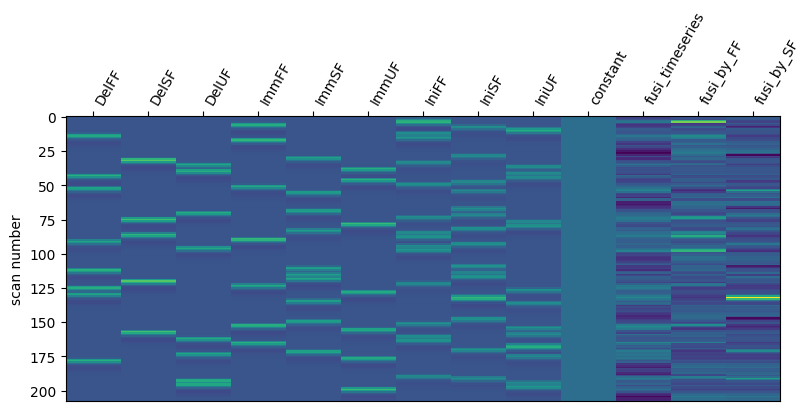

In [18]:
events_per_run = []
for run, events_file in enumerate(events_files):
    events_df = pandas.read_table(events_file)
    events_df = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])
    events_per_run.append(events_df) 

frame_times = numpy.linspace(0, (nvols - 1) * TR, nvols) + slice_time_ref # adjust for slice-timing

first_level_model = nilearn.glm.first_level.make_first_level_design_matrix(frame_times, 
                                                                           events = events_per_run[0], 
                                                                           hrf_model = 'spm', 
                                                                           high_pass = 0, 
                                                                           drift_order = None)
first_level_model['fusi_timeseries'] = scipy.stats.zscore(fusi_data_per_run[0])
first_level_model['fusi_by_FF'] = scipy.stats.zscore(first_level_model['IniFF'])*first_level_model['fusi_timeseries']
first_level_model['fusi_by_SF'] = scipy.stats.zscore(first_level_model['IniSF'])*first_level_model['fusi_timeseries']

nilearn.plotting.plot_design_matrix(first_level_model, output_file=None)
fig = plt.gcf(); fig.set_size_inches(8,4); plt.show();

The two PPI terms at the right of the design matrix can be used to detect voxels/ROIs whose relation to the fusiform timeseries depends on whether an FF (for penultimate regressor) or SF (ultimate regressor) trial occurs. The "fusi_timeseries" regressor adjusts for the mean relationship between the fusiform and other voxels/ROIs (functional connectivity), while the rest of the design matrix adjusts for the main effects of task (stimulus-driven activation for each trial-type). Note that it is important to mean-correct (here by Z-scoring) regressors before multiplying them together to create the interaction effect, to reduce the correlation between the interaction term and main effects (see https://github.com/RikHenson/Notebooks/blob/main/PowerForInteractions.pdf for more discussion of interactions).

**However, a really important note**: the PPI interaction terms are not strictly correct for event-related designs that engender very brief bursts of neural activity. This is because we really care about the product of the neural timeseries, rather than the product of the HRF-convolved timeseries, and mathematicaly *hrf(n1 x n2)* is not always equal to *hrf(n1) x hrf(n2)*, where *n1* and *n2* are the neural timeseries in two ROIs/voxels, and *hrf(n)* is the convolution of that neural activity by an HRF. These two terms are similar enough when *n1* and *n2* only contain low-frequency (slow neural) changes, such as in blocked-designs (for which PPIs were originally designed). However, the two terms can differ if *n1* and/or *n2* contain rapid changes, because such high frequency information is lost when convolved with the HRF. Some techniques have been developed that attempt to deconvolve the BOLD timeseries to estimate neural activity (e.g., using shrinkage priors on wavelets), which can then be multiplied together before being convolved with the HRF again, but I am not convinced of their accuracy (since if such deconvolution were possible, we could routinely apply to all BOLD data to estimate underlying neural activity!). For this reason, **you should be wary of PPI when performed on event-related designs, including the present example** (or at least situations where neural activity is not artificially slowed-down by using, for example, a blocked design).

**Excercise:** Unfortunately the present dataset does not really have a true blocked manipulation (e.g, instructions to sustain attention to one stimulus property versus another), though you may remember that it does have occasional periods of ~30s when no trials occur. Thus, rather than trying to test whether connectivity differs for FF and SF trials, as in the current example, you could construct a PPI to test whether connectivity differs for all trials versus baseline. For this, you would need to combine the onsets of all trials into one regressor, and multiply this regressor by the physiological (eg fusiform) timeseries. Some code for this is commented out below. Because this combined-trial regressor would necessarily be low-frequency, given the many trials bunched together before periods of rest, the convolution equivalence above is more likely to be met. The scientific interpretation of any such PPI would be less interesting however - just revealing voxels that are differentially connected when responding to blocks of faces/scrambled faces versus during passive fixation (in fact, if you do uncomment the code below, you will see mostly reduced correlation between FFA and rest of brain during blocks of faces than during rest; this is often found, ie resting-state correlations are higher than task-based ones). 

Anyway, continuing with the event-related PPI, in order to illustrate the logic of a PPI, even if its assumptions are unlikely to be met, we need to specify a full design matrix for each run, with usual confounds and filtering, etc

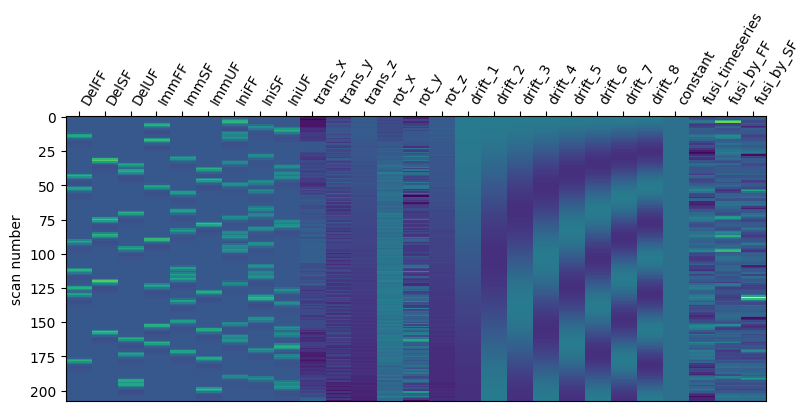

In [19]:
# get confounds
confound_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'confounds', 
    extension = ".tsv", 
    return_type = 'filename'
)
relevant_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pandas.read_table(conf_file)
    conf_subset = this_conf[relevant_confounds].fillna(0) # replace NaN with 0
    confounds_for_glm.append(conf_subset)

first_level_model_per_run = []
for run in range(len(bold)):
    first_level_model = nilearn.glm.first_level.make_first_level_design_matrix(frame_times, 
                                                                               events = events_per_run[run], 
                                                                               add_regs = confounds_for_glm[run],
                                                                               hrf_model = 'spm', 
                                                                               drift_model = 'cosine', 
                                                                               high_pass = 0.01, 
                                                                               drift_order = None)                                                                              
    # event-related PPI
    first_level_model['fusi_timeseries'] = scipy.stats.zscore(fusi_data_per_run[run])
    first_level_model['fusi_by_FF'] = scipy.stats.zscore(first_level_model['IniFF'])*first_level_model['fusi_timeseries']
    first_level_model['fusi_by_SF'] = scipy.stats.zscore(first_level_model['IniSF'])*first_level_model['fusi_timeseries']
    first_level_model_per_run.append(first_level_model) 

    # more block-like PPI (uncomment below and comment above):
#    first_level_model['physio_timeseries'] = scipy.stats.zscore(fusi_data_per_run[run])
#    first_level_model['psycho_timeseries'] = scipy.stats.zscore(numpy.sum(first_level_model[conditions],axis=1))
#    first_level_model['PPI'] = scipy.stats.zscore(first_level_model['psycho_timeseries']*first_level_model['physio_timeseries'])
    
nilearn.plotting.plot_design_matrix(first_level_model_per_run[0], output_file=None)
fig = plt.gcf(); fig.set_size_inches(8,4); plt.show();

You could apply a PPI to each of pairs of ROIs, like we did initially for BSR above, but it is more often used in a whole-brain search for any voxels whose connectivity with the seed region varies with the psychological manipulation. To do this, we need to pass the PPI design matrices created above, along with other specifications for the GLM, such as 10mm smoothing, to a function that will fit all runs in one go: 

In [20]:
# Set-up GLM parameters
fmri_glm = FirstLevelModel(smoothing_fwhm = 10,
                           noise_model = 'ar1', 
                          );
fmri_glm_multirun = fmri_glm.fit(bold, design_matrices=first_level_model_per_run)

Now we can use a contrast to test whether functional connectivity from the fusiform seed differs depending on whether a famous face or scrambled face is presented:

In [21]:
FF_index = first_level_model_per_run[0].columns.get_loc('fusi_by_FF')
SF_index = first_level_model_per_run[0].columns.get_loc('fusi_by_SF')
#FF_index = first_level_model_per_run[0].columns.get_loc('fusi_timeseries') # to look at basic functional connectivity (residuals after removing trial effects)
#SF_index = []

contrast_per_run = []
for run in range(len(bold)):
    contrast_val = numpy.zeros((1,first_level_model_per_run[0].shape[1]))
    contrast_val[0][FF_index] = 1
    contrast_val[0][SF_index] = -1
    contrast_per_run.append(contrast_val)
print(contrast_per_run)

# Uncommment below if you want to test PPI for blocks of all trials vs rest instead (having uncommented lines in earlier cell too)
#PPI_index = first_level_model_per_run[0].columns.get_loc('PPI')
#contrast_per_run = []
#for run in range(len(bold)):
#    contrast_val = numpy.zeros((1,first_level_model_per_run[0].shape[1]))
#    contrast_val[0][PPI_index] = 1
#    contrast_per_run.append(contrast_val)
#print(contrast_per_run)

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1.]]), array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1.]]), array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1.]]), array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1.]]), array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1.]]), array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1.]]), array([[ 0.,  0.,  0.,  0.,

Note that you could also evaluate a contrast [1] on the fusiform regressor (uncommenting third and fourth lines above), which would reveal voxels that show basic (positive) functional connectivity with the fusiform (though this would of course be circular for voxels actually within the fusiform ROI).

Now let's test this PPI contrast across the whole brain:

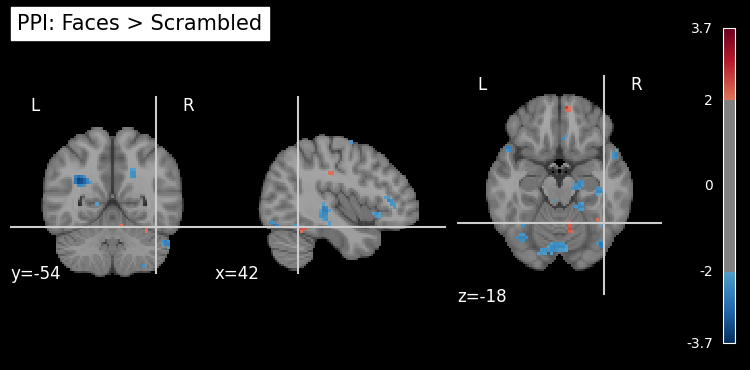

In [22]:
z_map = fmri_glm_multirun.compute_contrast(
    contrast_per_run,
    output_type="z_score",
)
fusi_coords = (42, -54, -18) 
#amyg_coords = (22, -6, -16) # from web!

nilearn.plotting.plot_stat_map(
    z_map,
    threshold = 2,
    cut_coords = fusi_coords, 
#    cut_coords = amyg_coords, 
    display_mode = 'ortho', 
    black_bg = True,
    title = 'PPI: Faces > Scrambled'
);

The results are very weak (even at this low threshold), possibly because the assumptions of the PPI are violated in our event-related dataset. Nonetheless, the code hopefully illustrates how a PPI can be done in principle.

Note if you want to generate a nice output, try

```bash
report = fmri_glm_multirun.generate_report(
    contrast_per_run,
    title="PPI",
)
report
```

This concludes this task-based functional connectivity notebook !